In [96]:
# once i have wholegenome_offset.trees
import pandas as pd
import tskit
import allel
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tsinfer
import pyslim
import json
import os
from collections import defaultdict

In [40]:
len(os.listdir('output_selection/'))

114

In [41]:
15*4

60

In [2]:
(30846.18/60)/60

8.568383333333333

## Part 2 : specific to each trait architecture

Delete all the sites and mutations that are not causal -> save tree ready for SLiM

In [3]:
n_ecotypes = 231
n_optima = 15

In [4]:
## for this im gonna use the og vcf file wth the offset to be able to map the positions correctly 
vcf_og = allel.read_vcf('../treeseq/wholegenome_offset.vcf')

geno_og = vcf_og["calldata/GT"]

In [5]:
alt_al_per_pos = geno_og.sum(axis=2) #.sum(axis=1)
alt_al_count = alt_al_per_pos.sum(axis=1)

In [6]:
pos = vcf_og['variants/POS']

In [7]:
alelle_dist = pd.DataFrame({'alt_al_count':alt_al_count, 'pos':pos})

alelle_dist['alt_al_freq'] = alelle_dist['alt_al_count'] / (n_ecotypes*2)

<AxesSubplot:xlabel='alt_al_freq', ylabel='Count'>

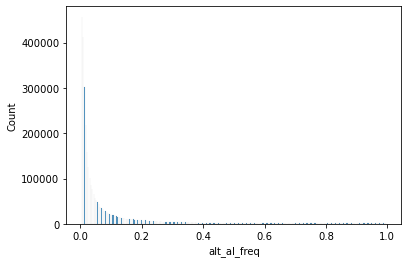

In [13]:
sns.histplot(alelle_dist['alt_al_freq'])

In [8]:
sim_freq_pos = alelle_dist[(alelle_dist['alt_al_freq'] <= 0.2 ) & (alelle_dist['alt_al_freq'] < 0.05)]['pos']

In [9]:
#selected_sites = sim_freq_pos.sample(20).values

In [10]:
selected_sites = [ 65390084,  86647787,  77511492,  34374633, 110678931,  57695772,
        35077561,  81043642,  84874598,  70762185,  67362119,  65335707,
        11251180,  82992833,  51228385,  31755559, 109852551,  89971662,
        76005668, 116232908]

In [11]:
#selected_sites = [16786062., 17435486., 18722427., 19304820., 19535796., 20546789.,
#       21204718., 21956162., 22302386., 22575472.]

In [12]:
#sc = np.random.rand(20).round(4)

In [13]:
sc = [0.0732, 0.7999, 0.2762, 0.8807, 0.76  , 0.1267, 0.9602, 0.8248,
       0.0202, 0.6144, 0.0908, 0.5946, 0.2736, 0.7769, 0.6367, 0.9308,
       0.7508, 0.7439, 0.9944, 0.9409]

In [14]:
#sc = [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 0.5, 0.5, 0.5]

In [15]:
pos_sc = pd.DataFrame({'pos': selected_sites, 'sc': sc})


In [16]:
#tables = new_ts.dump_tables()

## Define original phenotpyes, environments and vs

In [17]:
mask_positions = pd.Series(vcf_og['variants/POS']).isin(selected_sites)

In [18]:
mask_positions.sum()

20

In [19]:
mask_positions.shape

(3235480,)

In [20]:
alt_al_per_pos_selected_sites = alt_al_per_pos[mask_positions]

In [21]:
phenotypes = []
for i in range(alt_al_per_pos_selected_sites.shape[1]):
    gen_effectsize = np.multiply(alt_al_per_pos_selected_sites[:, i] , sc)
    phenotypes.append(gen_effectsize.sum())

In [235]:
sns.histplot(phenotypes)

NameError: name 'phenotypes' is not defined

In [23]:
max_pheno = max(phenotypes)
min_pheno = min(phenotypes)

length = max_pheno - min_pheno
step = length/(int(n_optima) - 1)
optima = [round(min_pheno + i * step, 4) for i in range(0, int(n_optima))]

In [24]:
optima = np.array(optima)

In [25]:
optima

array([0.    , 0.2792, 0.5585, 0.8377, 1.1169, 1.3961, 1.6754, 1.9546,
       2.2338, 2.5131, 2.7923, 3.0715, 3.3507, 3.63  , 3.9092])

In [26]:
## i will define 4 different levels of selection strength based on how well you do in the other environemnt 

## in the first case, you fitness will be almost 0 in the next environment, meaning strong selection 
## in the second case, your fitness will reach almost 0 in 5 environments next to you 
## in teh forth case your fitness will reach 0 in the other extreme environment
## in the last case your fitness will reach 0 in the double the environemnts available, meaninig that your fitness will still be something in the other extreme environment 

In [27]:
range_pheno = max_pheno - min_pheno
dist_between_env = range_pheno / len(optima)

In [28]:
## first case 
sd1 = dist_between_env / 3 ## 3 sd wil be in between environments 
variance1 = sd1**2

## second case 
sd2 = (dist_between_env * 5) / 3 ## 3 sd will be in between 5 environments 
variance2 = sd2**2

## third case 
sd3 = (dist_between_env * 15) / 3 ## 3 sd will be in between 15 environments which is the total number of environments 
variance3 = sd3**2

## fourth case 
sd4 = (dist_between_env * 30) / 3 ## 3 sd will be in between 15 environments which is the total number of environments 
variance4 = sd4**2


In [29]:
variances = [sd1, sd2, sd3, sd4]

In [30]:
### create the files for teh optimas and for the variances

In [31]:
file_path = 'optimas.txt'
# Open the file in write mode
with open(file_path, 'w') as file:
    for element in optima:
        file.write(str(element) + '\n')  # Write element followed by a newline

In [32]:
file_path = 'variances.txt'
# Open the file in write mode
with open(file_path, 'w') as file:
    for element in variances:
        file.write(str(round(element,4)) + '\n')  # Write element followed by a newline

In [148]:
range_pheno = max_pheno - min_pheno
dist_between_env = range_pheno / len(optima)

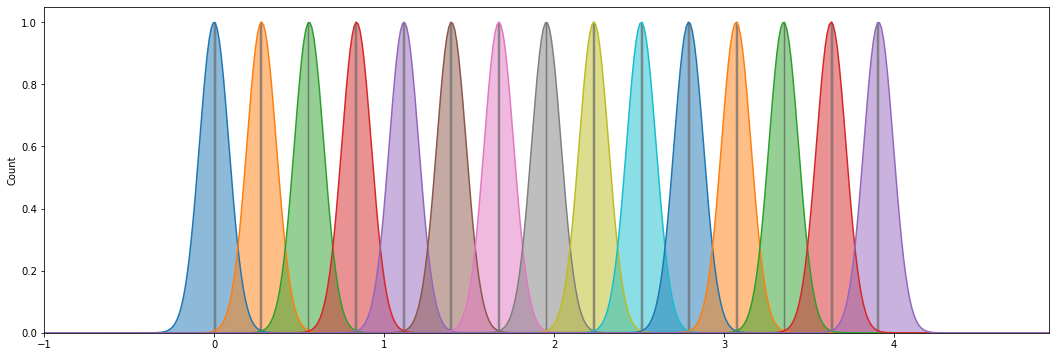

In [179]:
sd = dist_between_env / 3
variance = sd**2
# Set the size of the plot
plt.figure(figsize=(18, 6))


# exp(-0.5 * (phenotype - (optima_value))^2);

# Set the mean and variance for the Gaussian curves
# Iterate over the optima_plot values and plot the corresponding Gaussian curve
for mean in optima:
    x = np.linspace(optima.min() - 1 , optima.max() + 1, 500)
    #y = np.exp(-0.5 * ((x - mean)/variance) ** 2)
    #y = np.exp(-((mean - x)** 2)/(2*variance))
    y = np.exp(-0.5 * ((x - mean)** 2)/variance)
    #y = np.exp(-0.5 * ((x - mean)** 2)/(variance))
    plt.plot(x, y,  label=f'Mean: {mean:.2f}')
    plt.fill_between(x, y, alpha=0.5)

plt.xlim(optima.min() - 1, optima.max() + 1)

sns.histplot(optima,binwidth=0.01, color = 'grey')
#plt.savefig('plot1_setup_arq/' + arq + '_shade.pdf', bbox_inches="tight",  transparent=True,
           #dpi = 1200)
# Display the plot
plt.show()

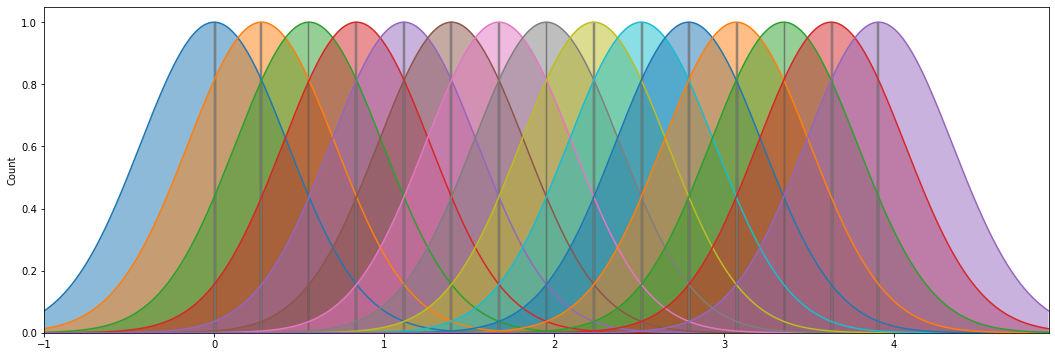

In [167]:
sd = (dist_between_env * 5) / 3
variance = sd**2
# Set the size of the plot
plt.figure(figsize=(18, 6))
# Set the mean and variance for the Gaussian curves
# Iterate over the optima_plot values and plot the corresponding Gaussian curve
for mean in optima:
    x = np.linspace(optima.min() - 1 , optima.max() + 1, 500)
    #y = np.exp(-0.5 * ((x - mean)/variance) ** 2)
    y = np.exp(-((mean - x)** 2)/(2*variance))
    plt.plot(x, y,  label=f'Mean: {mean:.2f}')
    plt.fill_between(x, y, alpha=0.5)

plt.xlim(optima.min() - 1, optima.max() + 1)

sns.histplot(optima,binwidth=0.01, color = 'grey')
#plt.savefig('plot1_setup_arq/' + arq + '_shade.pdf', bbox_inches="tight",  transparent=True,
           #dpi = 1200)
# Display the plot
plt.show()

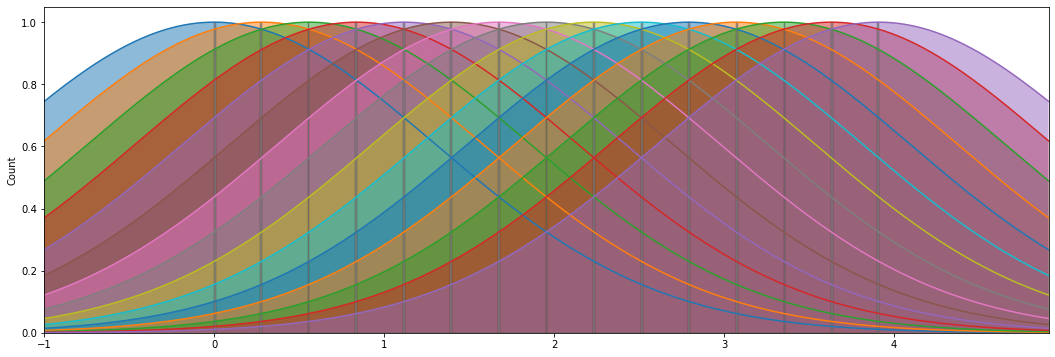

In [171]:
sd = (dist_between_env * 15) / 3
variance = sd**2
# Set the size of the plot
plt.figure(figsize=(18, 6))


# Set the mean and variance for the Gaussian curves
# Iterate over the optima_plot values and plot the corresponding Gaussian curve
for mean in optima:
    x = np.linspace(optima.min() - 1 , optima.max() + 1, 500)
    #y = np.exp(-0.5 * ((x - mean)/variance) ** 2)
    y = np.exp(-((mean - x)** 2)/(2*variance))
    plt.plot(x, y,  label=f'Mean: {mean:.2f}')
    plt.fill_between(x, y, alpha=0.5)

plt.xlim(optima.min() - 1, optima.max() + 1)

sns.histplot(optima,binwidth=0.01, color = 'grey')
#plt.savefig('plot1_setup_arq/' + arq + '_shade.pdf', bbox_inches="tight",  transparent=True,
           #dpi = 1200)
# Display the plot
plt.show()

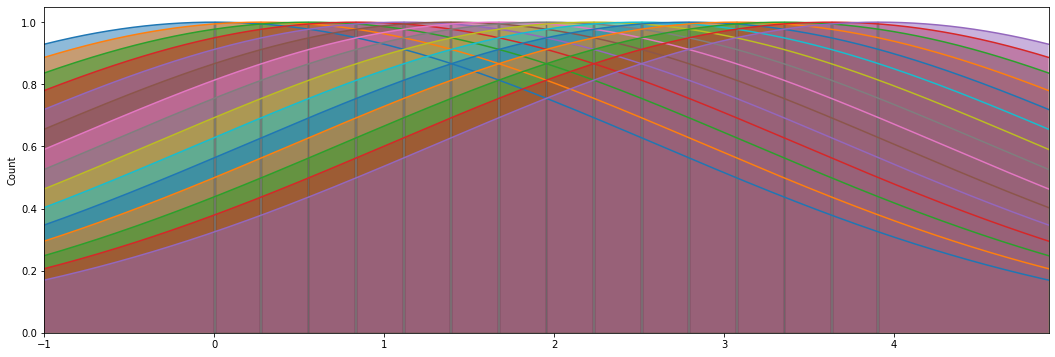

In [170]:
sd = (dist_between_env * 30) / 3
variance = sd**2
# Set the size of the plot
plt.figure(figsize=(18, 6))

# exp(-0.5 * (phenotype - (optima_value))^2);
# Set the mean and variance for the Gaussian curves
# Iterate over the optima_plot values and plot the corresponding Gaussian curve
for mean in optima:
    x = np.linspace(optima.min() - 1 , optima.max() + 1, 500)
    #y = np.exp(-0.5 * ((x - mean)/variance) ** 2)
    y = np.exp(-((mean - x)** 2)/(2*variance))
    plt.plot(x, y,  label=f'Mean: {mean:.2f}')
    plt.fill_between(x, y, alpha=0.5)

plt.xlim(optima.min() - 1, optima.max() + 1)

sns.histplot(optima,binwidth=0.01, color = 'grey')
#plt.savefig('plot1_setup_arq/' + arq + '_shade.pdf', bbox_inches="tight",  transparent=True,
           #dpi = 1200)
# Display the plot
plt.show()

In [ ]:
fitness = exp(-0.5 * ((phenotype - optima_value)^2)/variance);


In [ ]:
x = 

In [ ]:
np.exp(-0.5 * ((x - mean)** 2)/variance)

### Delete all the sites and mutations that are not causal 

In [117]:
ts = tskit.load('../treeseq/wholegenome_offset_baselinetree.trees')

In [118]:
tables = ts.dump_tables()

In [119]:
complete_sites = pd.Series(tables.sites.position)

In [120]:
complete_sites.name = 'complete_sites'

In [121]:
mask_delete_sites = pd.merge(complete_sites, pos_sc['pos'], left_on = 'complete_sites', right_on = 'pos', how = 'left')['pos'].notna()

In [122]:
tables.sites.replace_with(tables.sites[mask_delete_sites])

In [123]:
tables.mutations.replace_with(tables.mutations[mask_delete_sites])

In [124]:
tables.mutations.site = np.array(range(0, len(tables.mutations))).astype('int32')

In [125]:
new_ts = tables.tree_sequence()

In [126]:
pos_table = pd.Series(tables.sites.position).reset_index()

In [127]:
right_order_pos = pos_sc.merge(pos_table, left_on='pos',right_on =0).sort_values('index')

In [128]:
new_ts = tables.tree_sequence()

In [129]:
tables = new_ts.dump_tables()

In [130]:
tables.sites.clear()
for s in new_ts.sites():
    tables.sites.append(s.replace(ancestral_state=""))

In [132]:
tables.mutations.clear()
for k, (m, sc) in enumerate(zip(new_ts.mutations(), right_order_pos['sc'])):
    mm = pyslim.default_slim_metadata('mutation_list_entry')
    mm['selection_coeff'] = sc
    tables.mutations.append(
        m.replace(derived_state=str(k), metadata={'mutation_list': [mm]})
    )


### Save tree ready for SLiM

In [133]:
new_ts = tables.tree_sequence()

new_ts.dump('simulation_selection_drift.trees')

In [65]:
tskit.load('simulation_selection_drift.trees')

### Analize SLiM results

In [ ]:
## functions

In [3]:
def overlap_neutral_mut (ts_new, ts, mapper_realid_metadataid):
    ## extract surviving ndoes and comapre them to our old ndoes to place mtuations in the right place
    surviving_nodes = []
    for i in ts_new.tables.nodes:
        surviving_nodes.append(i.metadata['slim_id'])
    ## new nodes id and the ids i gave them in the past
    new_mapper = pd.DataFrame({'new_ids': range(0, len(ts_new.tables.nodes)), 'my_ids_metadata':surviving_nodes})
    ## map old nodes with new nodes
    mapper_lost_nodes = new_mapper.merge(mapper_realid_metadataid, left_on = 'my_ids_metadata', right_on = 'my_ids_metadata', how= 'right')

    ## create a mask to only keep from the old nodes the ones that survived the simulation
    mask = mapper_lost_nodes['new_ids'].notna()

    tables_og = ts.dump_tables()

    ## now filter old tables only based on surviving nodes 
    tables_og.nodes.replace_with(tables_og.nodes[mask])

    ## now filter mutation table based on the surviving nodes, for that, extract the nodes 
    old_nodes = tables_og.mutations.node

    old_nodes = pd.Series(old_nodes)

    old_nodes.name = 'old_nodes'

    ## create a dataframe relating the new and old nodes
    replace_oldbynew_nodes = pd.merge(old_nodes, mapper_lost_nodes, left_on ='old_nodes', right_on = 'real_id', how= 'left')

    ## create a mask to filter out all the mutations than has been lost 
    mask_mutations_lost = replace_oldbynew_nodes['new_ids'].notna()

    ## filter out mutations that has been lost 
    table_mutations = tables_og.mutations[mask_mutations_lost]

    ## now replace the old nodes ids by the new nodes ids with the mapper
    ids_to_replace = replace_oldbynew_nodes.dropna()['new_ids']
    table_mutations.node = np.array(ids_to_replace.astype('int32'))

    ## and jsut set the sites from 0 to the length of mutation table 
    table_mutations.site = np.array(range(0, len(table_mutations))).astype('int32')

    ## apply the same filter from the mutations table to the sites table 
    table_sites = tables_og.sites[mask_mutations_lost]  

    ## now replace all this filter old tables in the new tree seq! 
    new_tables = ts_new.dump_tables()

    new_tables.mutations.replace_with(table_mutations)

    new_tables.sites.replace_with(table_sites)

    ## make sure to compure mutations parents
    new_tables.compute_mutation_parents()

    ## create tree seq based on tables
    tree_nm = new_tables.tree_sequence()

    return tree_nm.simplify()

In [4]:
def convert_tree_to_vcf (tree,name_vcf):
    # create a vcf file from the treeseq 
    with open(name_vcf, 'w') as file:
        # Pass the file object as the output parameter
        tree.write_vcf(output=file)

In [5]:
#import the old tree
ts_old = tskit.load("../treeseq/wholegenome_offset_baselinetree.trees")
#import mapper old nodes to new nodes
mapper_realid_metadataid = pd.read_csv('../treeseq/mapper_realid_metadataid_wholegenome.csv')

In [48]:
#phenotypes = pd.read_csv('drift.txt',skiprows=14,header=None).T

# drop the alst value is corrupted
#phenotypes = phenotypes.drop(len(phenotypes) - 1)

## this is not a good meassure of the phenotypes beacuase i am inflated at 0 since there were a lot of the 0 ones anyways 
#phenotypes[0].value_counts()

In [5]:
def generate_nonhet_pos():
    vcf = allel.read_vcf('../treeseq/wholegenome_offset.vcf')
    ## extract the genotype from the vcf file
    geno = vcf["calldata/GT"]
    ## calcualte the genotype counts
    geno = allel.GenotypeArray(vcf["calldata/GT"])
    het_sites = geno.count_het(axis=1)
    mask_non_het_sites = het_sites==0 
    nonhet_pos = vcf['variants/POS'][mask_non_het_sites]
    pd.Series(nonhet_pos).to_csv('nonhet_pos_wholegenome_offset.csv')
    return

def filtering_pos (nonhet_pos, pos_new, geno_og, geno_new):
    pos_to_keep = np.intersect1d(nonhet_pos, pos_new)
    mask_pos_ogvcf = pd.Series(pos_og).isin(pos_to_keep)
    geno_og_rpos  = geno_og[mask_pos_ogvcf]
    mask_pos_newvcf = pd.Series(pos_new).isin(pos_to_keep)
    geno_new_rpos  = geno_new[mask_pos_newvcf]
    return geno_og_rpos, geno_new_rpos
    

def get_ecotype_geno_mapper(geno_og_rpos):
    geno_og_rpos = np.swapaxes(geno_og_rpos, 0, 1)
    ecotype_geno_mapper = {}
    for i,j in zip(geno_og_rpos, samples):
        geno = i.tobytes()
        ecotype_geno_mapper[geno] = j
    return ecotype_geno_mapper

def get_ecotype_counts(geno_new_rpos, pop_name):
    geno_new_rpos = np.swapaxes(geno_new_rpos, 0, 1)
    # Initialize a defaultdict to store the genotype counts
    ecotype_counts = defaultdict(int)
    # Count genotypes in geno_drift_resh
    for i in geno_new_rpos:
        sample = i.tobytes()
        ecotype = ecotype_geno_mapper.get(sample, 'other')
        ecotype_counts[ecotype] += 1
    name = 'count'+ pop_name
    ecotype_countsdf = pd.DataFrame(list(ecotype_counts.items()), columns=['ecotype', name])
    ecotype_countsdf['ecotype'] = ecotype_countsdf['ecotype'].str.split('_').str[0]
    return ecotype_countsdf

Import the info form the og_vcf to build the mapper

In [7]:
nonhet_pos = np.array(pd.read_csv('nonhet_pos_wholegenome_offset.csv',usecols=[1])['0'])

vcf_og = allel.read_vcf('../treeseq/wholegenome_offset.vcf', fields=['calldata/GT', 'variants/POS', 'samples'])
geno_og = vcf_og['calldata/GT']
pos_og = vcf_og['variants/POS']
samples = vcf_og['samples']

Importing drift simulations

In [ ]:
## import each of the drift trees, add mutations and save their vcf file 
for i in range(1,10):
    ts_new = tskit.load(f'output_drift/drift_run{i}_result.trees')
    ts_nm = overlap_neutral_mut(ts_new, ts_old, mapper_realid_metadataid)
    convert_tree_to_vcf(ts_nm, f'output_drift/result_drift{i}.vcf')

In [44]:
ecotypes_grenenet = pd.read_csv('ecotypes_grenenet.txt',header=None, dtype=object)
ecotypes_grenenet.columns= ['ecotype']
ecotypes_grenenet = pd.concat([ecotypes_grenenet, pd.DataFrame(data = {'ecotype': ['other']}, index=[231])],axis=0)

In [ ]:
for i in range(1,10):
    ## import each of teh vcf realted to the drift simulation
    vcf_new = allel.read_vcf(f'result_drift{i}.vcf', fields = ['calldata/GT', 'variants/POS'])
    ##extract the posisions and the geno array
    pos_new = vcf_new['variants/POS']
    geno_new = vcf_new['calldata/GT']
    ## for each of them create the ecotype geno mapper, depending on the positions that made it 
    geno_og_rpos, geno_new_rpos = filtering_pos (nonhet_pos, pos_new, geno_og, geno_new)
    ecotype_geno_mapper = get_ecotype_geno_mapper(geno_og_rpos)
    ecotype_countsdf = get_ecotype_counts(geno_new_rpos, f'drift{i}')
    ## merge with previous 
    ecotypes_grenenet = ecotypes_grenenet.merge(ecotype_countsdf, how='left', on ='ecotype')
ecotypes_grenenet.to_csv('ecotype_counts_drift.csv')

Importing selection simulations

In [49]:
variances = pd.read_csv('variances.txt',header=None)[0]
optimas = pd.read_csv('optimas.txt',header=None)[0]

In [ ]:

## import each of the selection trees, add mutations and save their vcf file 
for i in variances:
    for j in optimas:
        file_name = f'output_selection/var{i}_optima{j}_result.trees'
        if os.path.exists(file_name) and os.path.getsize(file_name) < 0:
            print('empty_tree')
            with open(f'output_selection/result_selection_var{i}_optima{j}.vcf', "w"):
                pass  # Create an empty vcf file 
        elif os.path.exists(file_name) and os.path.getsize(file_name) > 0:
            print('tree with individuals')
            ts_new = tskit.load(file_name)
            ts_nm = overlap_neutral_mut(ts_new, ts_old, mapper_realid_metadataid)
            convert_tree_to_vcf(ts_nm, f'output_selection/result_selection_var{i}_optima{j}.vcf')

In [ ]:
ecotypes_grenenet = pd.read_csv('ecotypes_grenenet.txt',header=None, dtype=object)
ecotypes_grenenet.columns= ['ecotype']
ecotypes_grenenet = pd.concat([ecotypes_grenenet, pd.DataFrame(data = {'ecotype': ['other']}, index=[231])],axis=0)

In [50]:
for i in variances:
    for j in optimas:
        vcf_filename = f'output_selection/result_selection_var{i}_optima{j}.vcf'
        # Check if the VCF file exists and is not empty (all individuals died)
        if os.path.exists(vcf_filename) and os.path.getsize(vcf_filename) > 0:
        
            ## import each of teh vcf realted to the drift simulation
            vcf_new = allel.read_vcf(vcf_filename, fields = ['calldata/GT', 'variants/POS'])
            ##extract the posisions and the geno array
            pos_new = vcf_new['variants/POS']
            geno_new = vcf_new['calldata/GT']
            ## for each of them create the ecotype geno mapper, depending on the positions that made it 
            geno_og_rpos, geno_new_rpos = filtering_pos (nonhet_pos, pos_new, geno_og, geno_new)
            ecotype_geno_mapper = get_ecotype_geno_mapper(geno_og_rpos)
            ecotype_countsdf = get_ecotype_counts(geno_new_rpos, f'_selection_var{i}_optima{j}')
            ## merge with previous 
            ecotypes_grenenet = ecotypes_grenenet.merge(ecotype_countsdf, how='left', on ='ecotype')
        elif os.path.exists(vcf_filename) and os.path.getsize(vcf_filename) == 0:
            empty_col_name = f'counts_selection_var{i}_optima{j}'
            print('added empty column in ' + empty_col_name)
            ecotypes_grenenet[empty_col_name] = 0
            
ecotypes_grenenet.to_csv('ecotype_counts_selection.csv')

{'other': 900}


Analize results

In [202]:
drift = pd.read_csv('ecotype_counts_drift.csv').drop(['Unnamed: 0'],axis=1)

In [128]:
selection = pd.read_csv('ecotype_counts_selection.csv').drop(['Unnamed: 0'],axis=1)

In [129]:
pop_size_drift = drift.iloc[:,1:].sum(axis=0).reset_index().rename(columns = {'index': 'name' , 0: 'pop_size' })

In [130]:
pop_size_selection = selection.iloc[:,1:].sum(axis=0).reset_index().rename(columns = {'index': 'name' , 0: 'pop_size' })

In [131]:
selection_melt = selection.drop(['ecotype'],axis=1).melt()

In [132]:
selection_melt.columns

Index(['variable', 'value'], dtype='object')

In [133]:
selection = selection.set_index('ecotype')

In [134]:
selection_var = selection.var(axis=0)

In [135]:
selection_var = selection_var.reset_index().replace(0, np.nan)

In [203]:
drift = drift.set_index('ecotype')

In [204]:
drift_var = drift.var(axis=0)

In [205]:
drift_var = drift_var.reset_index().replace(0, np.nan)

In [139]:
drift_melt = drift.melt()

<AxesSubplot:xlabel='value', ylabel='Count'>

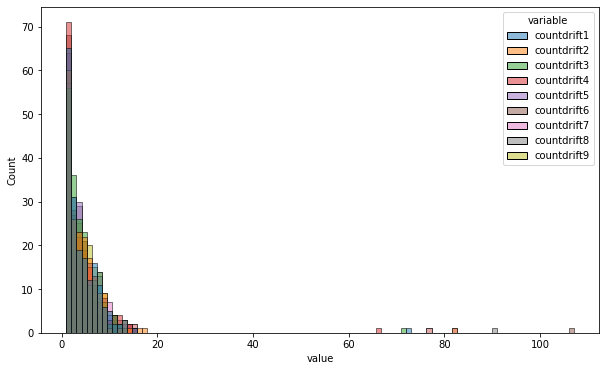

In [140]:
plt.figure(figsize=(10, 6))
sns.histplot(drift_melt, x = 'value', hue='variable', bins= 100)

In [123]:
selection_melt

,variable,value
0,Unnamed: 0,0.0
1,Unnamed: 0,1.0
2,Unnamed: 0,2.0
3,Unnamed: 0,3.0
4,Unnamed: 0,4.0
...,...,...
13915,count_selection_var2.6061_optima3.9092,NaN
13916,count_selection_var2.6061_optima3.9092,NaN
13917,count_selection_var2.6061_optima3.9092,NaN
13918,count_selection_var2.6061_optima3.9092,NaN


In [141]:
drift_selection = pd.concat([drift_var, selection_var],axis=0)

In [149]:
selection_var['optima'] = selection_var['index'].str.split('_').str[-1]
selection_var['variance'] = selection_var['index'].str.split('_').str[-2]

In [218]:
selection_var = selection_var.drop('index',axis=1)

selection_var_pt = selection_var.pivot_table(index = 'optima', columns= 'variance')

<AxesSubplot:xlabel='None-variance', ylabel='optima'>

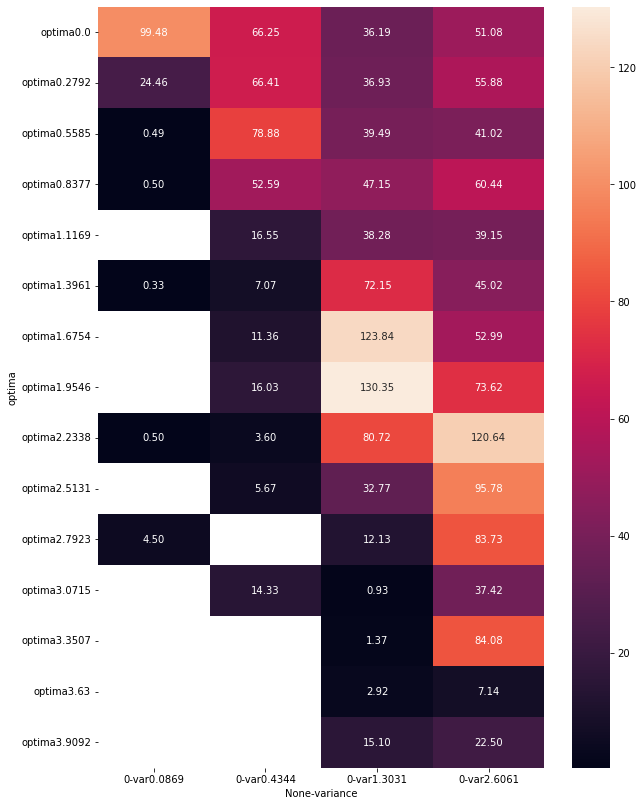

In [158]:
plt.figure(figsize=(10, 14))
sns.heatmap(selection_var_pt,  annot=True, fmt=".2f")

In [164]:
drift_var[0]

0    33.816644
1    41.419729
2    30.444092
3    29.246555
4    39.980910
5    66.737074
6    39.291422
7    49.709672
8    36.027899
Name: 0, dtype: float64

In [206]:
## add dummies just to match index 
drift_var = pd.concat([drift_var, pd.DataFrame({'index': [np.nan]*6, 0:[np.nan]*6})])

In [208]:
drift_var = drift_var.set_index(selection_var_pt.index)

In [182]:
selection_var_pt['drift'] = drift_var[0]

In [177]:
selection_var_pt.columns = ['var0.0869','var0.4344','var1.3031','var2.6061']

In [221]:
selection_var_pt.columns = selection_var_pt.columns.to_flat_index()

In [225]:
result = pd.concat([selection_var_pt, drift_var[0]], axis=1)

In [227]:
result.columns = ['var0.0869', 'var0.4344', 'var1.3031','var2.6061', 'drift']

In [233]:
result = result[['drift','var0.0869', 'var0.4344', 'var1.3031','var2.6061']]

<AxesSubplot:ylabel='optima'>

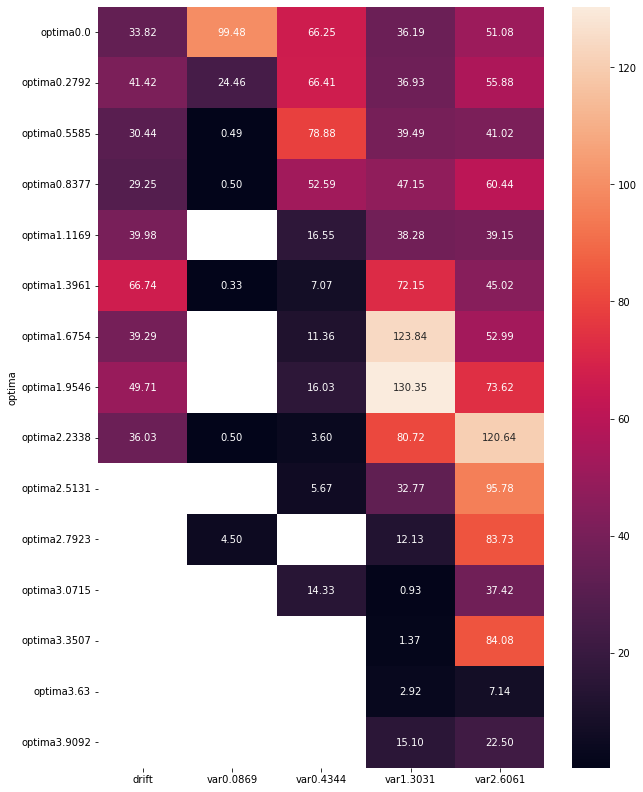

In [234]:
plt.figure(figsize=(10, 14))
sns.heatmap(result,  annot=True, fmt=".2f")

In [104]:
## create a plot showing the sixze of the population, the inital variance 

## maybe i can also simulate different initial population sizes 

# i think that the variance is not a go

In [238]:
selectiont = selection.T

In [241]:
selectiont = selectiont.reset_index()

In [246]:
selectiont['optima'] = selectiont['index'].str.split('_').str[-1]
selectiont['variance'] = selectiont['index'].str.split('_').str[-2]

In [248]:
selectiont = selectiont.drop('index',axis=1)

selectiont_pt = selectiont.pivot_table(index = 'optima', columns= 'variance')

In [274]:
name = 'count_selection_var0.0869_optima0.0'

In [278]:
name.split('_')[-2] + '_' +  name.split('_')[-1]

'var0.0869_optima0.0'

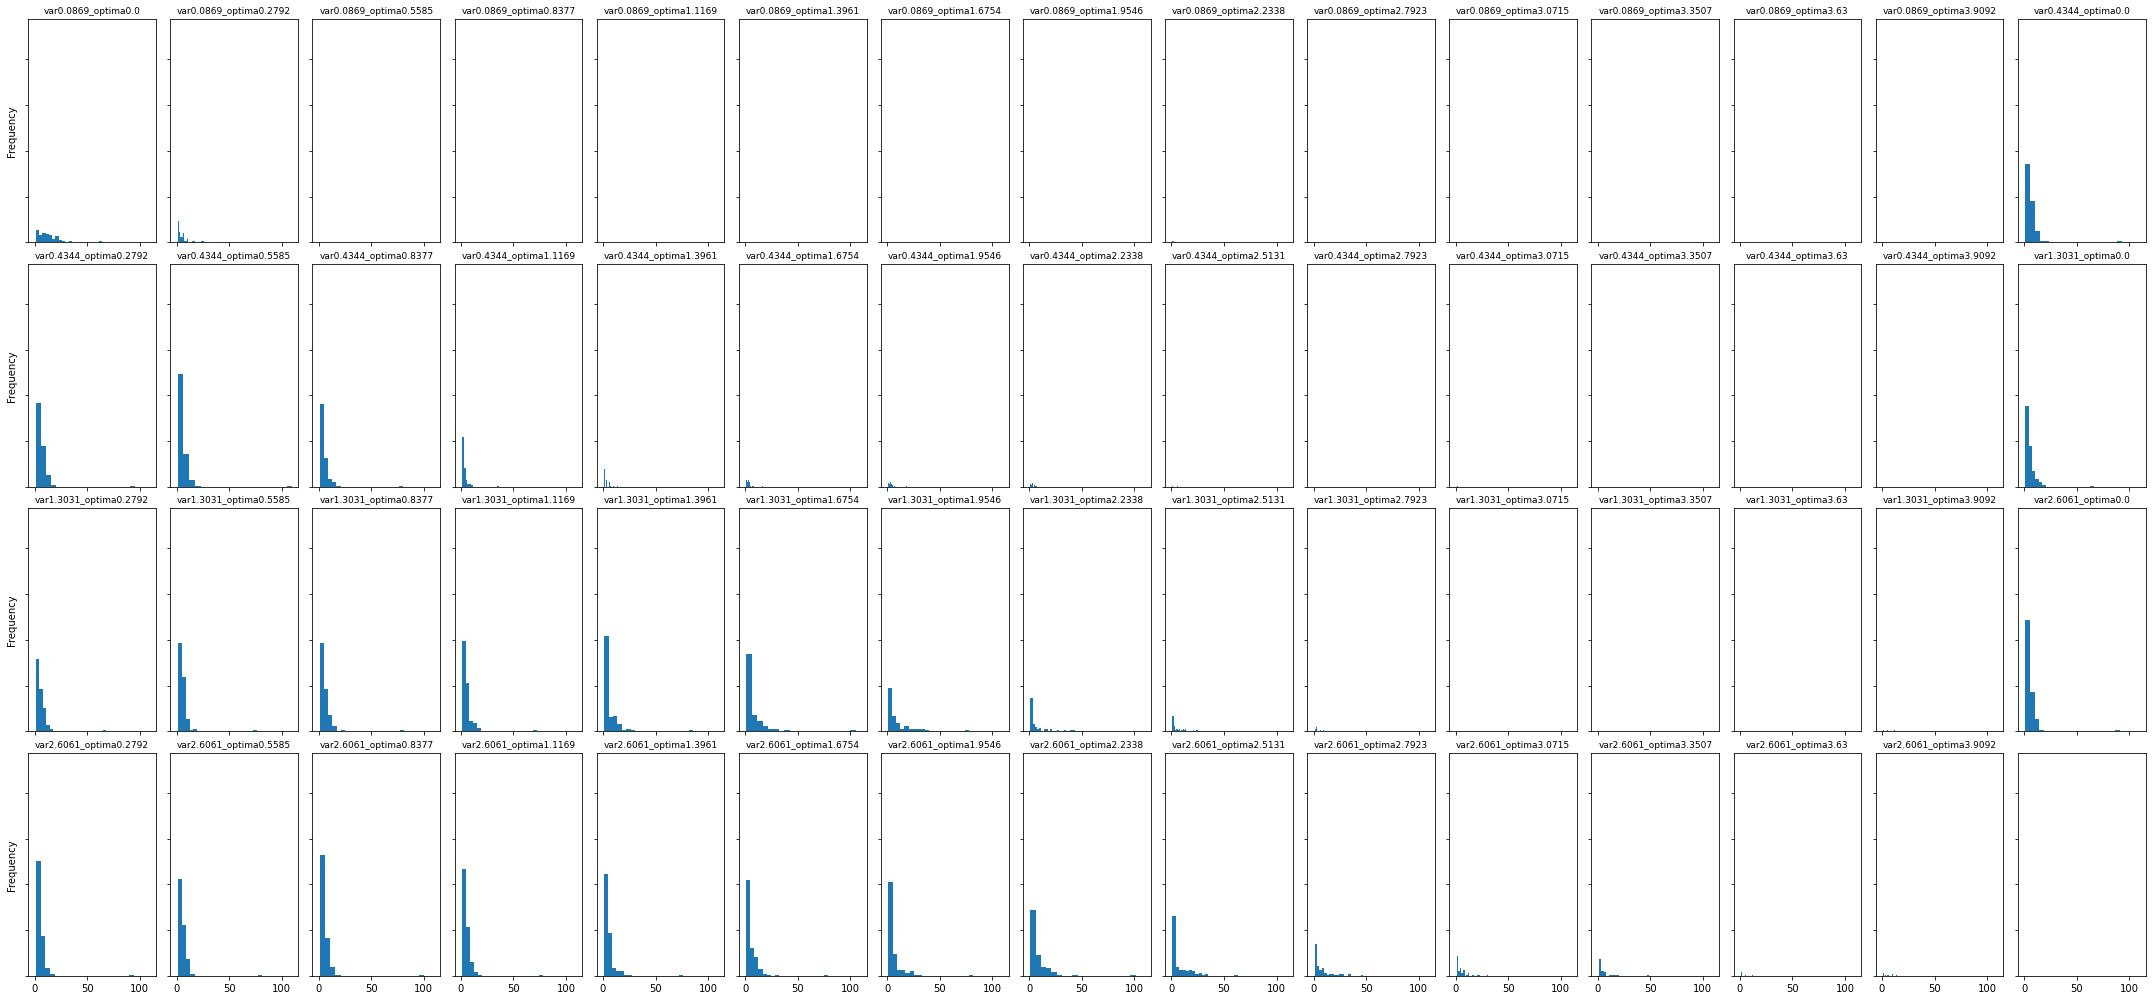

In [282]:
# Calculate the number of rows and columns for the grid
# Calculate the number of rows and columns for the grid
n_rows = 4
n_cols = 15

# Create a figure and axis for subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30,14), sharey=True, sharex=True)

axes = axes.flatten()

# Loop through columns and create histograms
for i, column in enumerate(selection.columns):
    ax = axes[i]  # Get the current subplot
    
    # Extract the last 6 digits of the column name as the title
    title = column.split('_')[-2] + '_' +  column.split('_')[-1]
    
    # Create histogram for the column
    selection[column].plot.hist(ax=ax, bins=20)
    
    # Set the title for the subplot with reduced clutter
    ax.set_title(title, fontsize=9)

    ax.grid(False)  # Turn off the background grid

    # Remove y-axis labels
    ax.set_yticklabels([])


# Adjust layout to reduce vertical margin
plt.tight_layout(h_pad=0.5)

# Show the plot
plt.show()

In [281]:
drift

,countdrift1,countdrift2,countdrift3,countdrift4,countdrift5,countdrift6,countdrift7,countdrift8,countdrift9
ecotype,,,,,,,,,
10002,6.0,4.0,4.0,1.0,NaN,NaN,8.0,2.0,6.0
10006,10.0,2.0,4.0,12.0,3.0,7.0,3.0,2.0,2.0
10011,3.0,NaN,1.0,5.0,NaN,4.0,8.0,4.0,2.0
10013,NaN,7.0,1.0,3.0,4.0,NaN,3.0,2.0,NaN
10014,NaN,NaN,5.0,1.0,NaN,5.0,3.0,5.0,7.0
...,...,...,...,...,...,...,...,...,...
6939,2.0,1.0,NaN,6.0,2.0,2.0,8.0,3.0,4.0
9940,9.0,1.0,6.0,NaN,3.0,2.0,1.0,NaN,6.0
9977,1.0,NaN,NaN,2.0,6.0,4.0,NaN,2.0,1.0


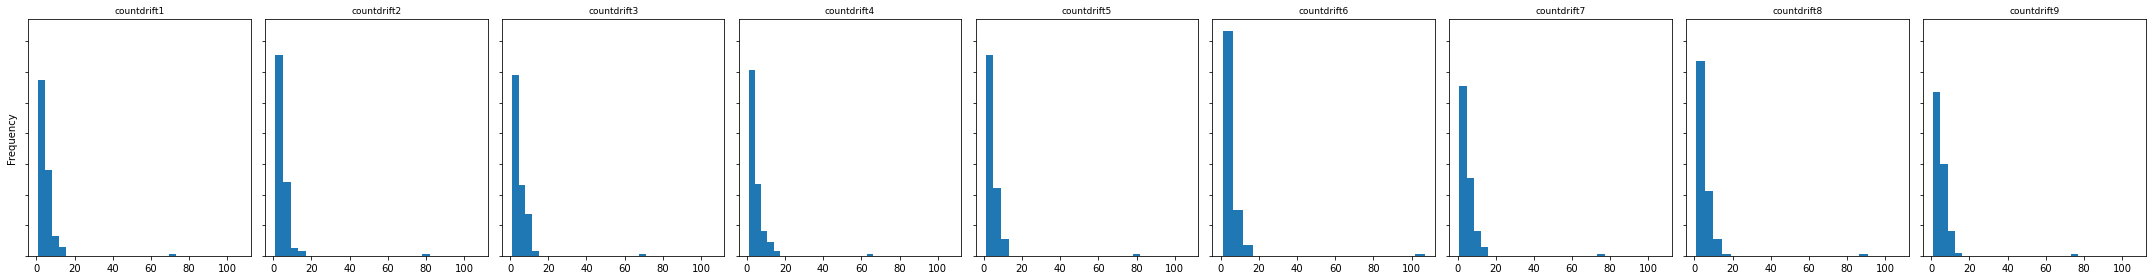

In [288]:
# Calculate the number of rows and columns for the grid
# Calculate the number of rows and columns for the grid

n_cols = 9

# Create a figure and axis for subplots
fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(30,4), sharey=True, sharex=True)

axes = axes.flatten()

# Loop through columns and create histograms
for i, column in enumerate(drift.columns):
    ax = axes[i]  # Get the current subplot
    
    # Extract the last 6 digits of the column name as the title
    title = column
    
    # Create histogram for the column
    drift[column].plot.hist(ax=ax, bins=20)
    
    # Set the title for the subplot with reduced clutter
    ax.set_title(title, fontsize=9)

    ax.grid(False)  # Turn off the background grid

    # Remove y-axis labels
    ax.set_yticklabels([])


# Adjust layout to reduce vertical margin
plt.tight_layout(h_pad=0.5)

# Show the plot
plt.show()